# 1. 威胁模型
- 对于上下文，有许多类别的对抗性攻击，每种攻击具有不同的目标和对攻击者知识的假设。然而，通常，总体目标是向输入数据添加最少 量的扰动以引起期望的错误分类。对攻击者的知识有几种假设，其中两种是：白盒子和黑盒子。白盒攻击假定攻击者具有对模型的全部 知识和访问权限，包括体系结构、输入、输出和权重。黑盒攻击假设攻击者只能访问模型的输入和输出，并且对底层架构或权重一无所知。 还有几种类型的目标，包括错误分类和源/目标错误分类。错误分类的目标意味着攻击者只希望输出分类错误，但不关心新分类是什么。 源/目标错误分类意味着攻击者想要更改最初属于特定源类的图像，以便将其归类为特定目标类。
- FGSM 攻击是一种白盒攻击，其目标是错误分类。有了这些背景信息，我们现在可以详细讨论攻击。

# 2. FGSM（Fast Gradient Sign Attack）
- 快速梯度标志攻击（FGSM），是迄今为止最早和最受欢迎的对抗性攻击之一，它由 Goodfellow 等人在[Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)中提出，是一种简单但是有效的对抗样本生成算法。它旨在通过利用模型学习的方式和渐变来攻击神经 网络。这个想法很简单，攻击调整输入数据以基于相同的反向传播梯度来最大化损失，而不是通过基于反向传播的梯度调整权重来最小化损失。 换句话说，攻击是利用损失函数的梯度，然后调整输入数据以最大化损失。
- 在进入代码之前，先讲一下著名的 FGSM 熊猫示例并提取一些符号。

<img src="https://cdn.nlark.com/yuque/0/2021/png/1508544/1614178182990-4e0de08b-6532-49cd-8b94-1e0d3e2ede96.png"/>

- 从图中可以看出，$x$是正确分类为“熊猫”的原始输入图像，$y$是$x$的基本事实标签， $\theta$代表模型参数，$J(\theta,x,y)$是用于训练网络的损失。攻击是反向将梯度传播回输入数据以计算$\nabla_xJ(\theta,x,y)$。 然后，它在一个方向上（即$sign(\nabla_xJ(\theta,x,y))$）调整输入数据（图中的$\epsilon$或0.007），这将使损失最大化。然后， 当目标网络仍然明显是“熊猫”时，由此产生的扰动图像被错误地分类为“长臂猿”。

# 3. 实现
## 3.1 引入相关包

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

## 3.2 输入
- 本教程只有三个输入，定义如下： 
- epsilons：用于运行的epsilon值列表。在列表中保留0非常重要，因为它表示原始测试集上的模型性能。而且，我们期望epsilon越大，扰 动就越明显，但就降低模型精度方面而言攻击越有效。由于此处的数据范围为[0,1]，因此epsilon值不应超过1。 
- pretrained_model：[pytorch/examples/mnist](https://github.com/pytorch/examples/tree/master/mnist)训练的预训练 MNIST 模型的路径。为简单起见，请在[此处](https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing) 下载预训练模型。 
- use_cuda：如果需要和可使用CUDA的布尔标志。注意，带有CUDA的GPU对本教程并不重要，因为本教程使用CPU不会花费太多时间。

In [3]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "Datasets/lenet_mnist_model.pth"
use_cuda=True

## 3.3 被攻击的模型
- 如上所述，受攻击的模型与[pytorch/examples/mnist](https://github.com/pytorch/examples/tree/master/mnist)中的 MNIST 模型 相同。您可以训练并保存自己的 MNIST 模型，也可以下载并使用提供的模型。此处的 Net 定义和测试数据加载器已从 MNIST 示例中复制。 本小节的目的是定义模型和数据加载器，然后初始化模型并加载预训练的权重。

In [4]:
# 定义LeNet模型
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

#声明 MNIST 测试数据集何数据加载
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./Datasets', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# 定义我们正在使用的设备
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 初始化网络
model = Net().to(device)

# 加载已经预训练的模型
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# 在评估模式下设置模型。在这种情况下，这适用于Dropout图层
model.eval()

CUDA Available:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

## 3.4 FGSM算法攻击
- 现在，我们可以通过扰乱原始输入来定义创建对抗性示例的函数。`fgsm_attack`函数有三个输入，`image`是原始的勿扰乱图像$(x)$，`epsilon`是像素方式的扰动量$(\epsilon)$，`data_grad`是输入图像的损失梯度$\nabla_xJ(\theta,x,y)$。然后该功能将扰动图像创建为:
    - $perturbed_{image}=image + epsilon * sign(data_{grad})=x + \epsilon * sign(\nabla_xJ(\theta,x,y))$
- 最后，为了保持数据的原始范围，将扰动的图像剪切到范围[0,1]。

In [5]:
# FGSM算法攻击代码
def fgsm_attack(image, epsilon, data_grad):
    # 收集数据梯度的元素符号
    sign_data_grad = data_grad.sign()
    # 通过调整输入图像的每个像素来创建扰动图像
    perturbed_image = image + epsilon*sign_data_grad
    # 添加剪切以维持[0,1]范围
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 返回被扰动的图像
    return perturbed_image

## 3.5 测试函数
- 最后，本教程的核心结果来自测试功能。每次调用此测试函数都会对 MNIST 测试集执行完整的测试步骤，并报告最终的准确性。但是，请注意， 此函数也需要输入`epsilon`。这是因为`test`函数展示受到强度为$\epsilon$的攻击下被攻击模型的准确性。 更具体地说，对于测试集中的每个样本，该函数计算输入数据$data_{grad}$的损失梯度，用`fgsm_attack（perturbed_data）` 创建扰乱图像，然后检查扰动的例子是否是对抗性的。除了测试模型的准确性之外，该函数还保存并返回一些成功的对抗性示例，以便稍后可视化。

In [6]:
def test( model, device, test_loader, epsilon ):

    # 精度计数器
    correct = 0
    adv_examples = []

    # 循环遍历测试集中的所有示例
    for data, target in test_loader:

        # 把数据和标签发送到设备
        data, target = data.to(device), target.to(device)

        # 设置张量的requires_grad属性，这对于攻击很关键
        data.requires_grad = True

        # 通过模型前向传递数据
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # 如果初始预测是错误的，不打断攻击，继续
        if init_pred.item() != target.item():
            continue

        # 计算损失
        loss = F.nll_loss(output, target)

        # 将所有现有的渐变归零
        model.zero_grad()

        # 计算后向传递模型的梯度
        loss.backward()

        # 收集datagrad
        data_grad = data.grad.data

        # 唤醒FGSM进行攻击
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 重新分类受扰乱的图像
        output = model(perturbed_data)

        # 检查是否成功
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # 保存0 epsilon示例的特例
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 稍后保存一些用于可视化的示例
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 计算这个epsilon的最终准确度
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 返回准确性和对抗性示例
    return final_acc, adv_examples

## 3.6 运行攻击
- 实现的最后一部分是实际运行攻击。在这里，我们为 epsilons 输入中的每个 epsilon 值运行一个完整的测试步骤。 对于每个epsilon，我们还 保存最终的准确性，并在接下来的部分中绘制一些成功的对抗性示例。注意随着 epsilon 值的增加，打印精度会如何降低。另外，请注意`ε= 0` 的情况表示原始测试精度，没有攻击。

In [9]:
accuracies = []
examples = []

# 对每个epsilon运行测试
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


# 4 结果
## 4.1 准确度 vs Epsilon
- 第一个结果是精度与 epsilon 图。如前所述，随着 epsilon 的增加，我们期望测试精度降低。这是因为较大的 epsilons 意味着我们朝着最 大化损失的方向迈出更大的一步。请注意，即使 epsilon 值线性分布，曲线中的趋势也不是线性的。例如，ε= 0.05 时的精度仅比 ε= 0 低 约 4％，但ε= 0.2 时的精度比 ε= 0.15 低 25％。另外，请注意在 ε= 0.25 和 ε= 0.3 之间模型的准确性达到10级分类器的随机精度。

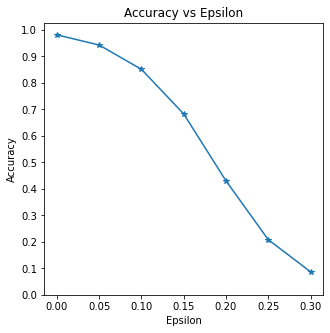

In [10]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

## 4.2 样本对抗性示例
- 正如天底下没有免费午餐。在这种情况下，随着 epsilon 增加，测试精度降低，但同时扰动也在变得更容易察觉。实际上，在攻击者必须考虑权衡 准确度降级和可感知性。在这里，我们展示了每个 epsilon 值的成功对抗性示例的一些例子。图的每一行显示不同的 epsilon 值。第一行是 ε= 0 的例子，它们代表没有扰动的原始“干净”图像。每个图像的标题显示“原始分类 - >对抗性分类。”注意，扰动在 ε= 0.15 时开始 变得明显，并且在 ε= 0.3 时非常明显。然而，在所有情况下，尽管增加了噪音，人类仍然能够识别正确的类别。

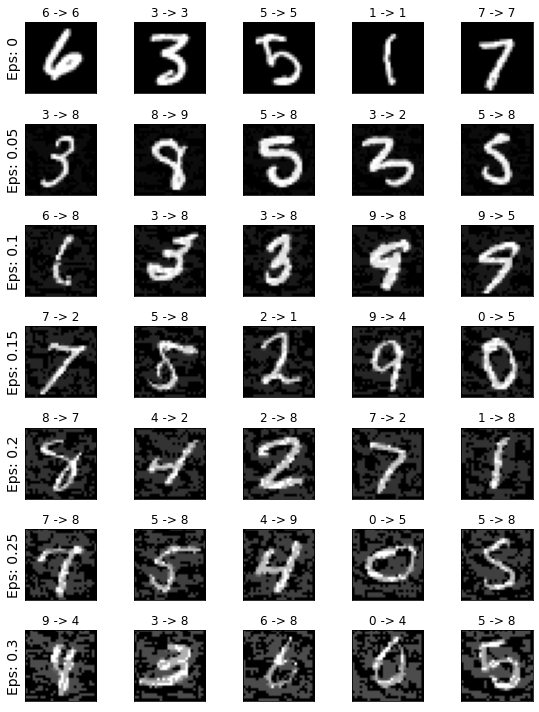

In [11]:
# 在每个epsilon上绘制几个对抗样本的例子
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# 练习题
在阿里天池新人赛上 安全AI挑战者计划第二期——ImageNet图像分类对抗攻击 进行实验。